# RDFIA: Practical work 3-a
## Bayesian Linear Regression
### Sorbonne Université 2024/25
### [Course link](https://rdfia.github.io/)
### GRUSS Carlos, RCHAKI Oussama

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal:** Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.

**Summary of the TP:**

Bayesian models are essential for incorporating uncertainty into machine learning and data analysis, addressing two critical types of uncertainty: 

* Epistemic uncertainty, which arises from a lack of knowledge or data about the model and can be reduced with more data, 
* Aleatoric uncertainty, which is inherent to the data itself and cannot be eliminated, such as measurement noise. 

By using probabilistic reasoning, Bayesian approaches provide a principled way to quantify and handle these uncertainties, enhancing model reliability. In particular, Bayesian linear regression extends traditional linear regression by treating model parameters as random variables with prior distributions, updated through Bayes' theorem to produce posterior distributions after observing data. This results in predictions represented as distributions, offering both point estimates and confidence intervals, making Bayesian linear regression especially valuable for tasks requiring uncertainty quantification and robust decision-making.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """
    Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range

    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot

    Returns:
      None
    """
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.xlim(xmin=xmin, xmax=xmax)
    plt.ylim(ymin=ymin, ymax=ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred,
                     color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred -
                     std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred +
                     std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred -
                     std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred +
                     std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin=xmin, xmax=xmax)
    plt.ylim(ymin=stdmin, ymax=stdmax)
    plt.plot(X_test, std_pred**2, color='red',
             label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1] > 1:
            training_domain.append([current_min, sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])

    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray',
                    label="Training area" if j == 0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")

    plt.legend()
    plt.show()

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [3]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5 * x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create training and test points
sigma = 0.2
nbpts = 25
dataset_linear = {}
dataset_linear["X_train"] = np.random.uniform(0, 2, nbpts)
dataset_linear["y_train"] = f_linear(
    dataset_linear["X_train"], noise_amount=1, sigma=sigma
)
dataset_linear["X_test"] = np.linspace(-10, 10, 10 * nbpts)
dataset_linear["y_test"] = f_linear(
    dataset_linear["X_test"], noise_amount=0, sigma=sigma
)

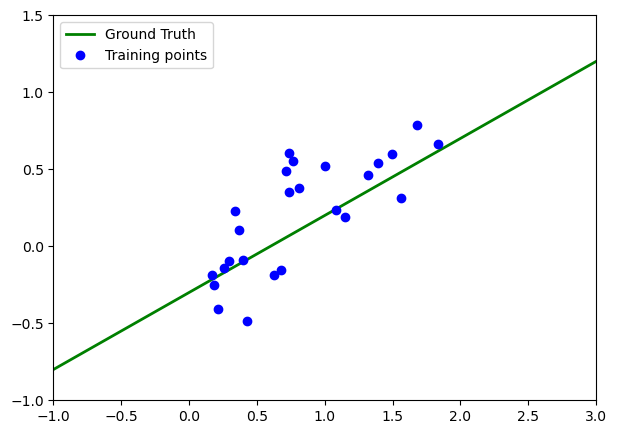

In [4]:
# Plot dataset
plt.figure(figsize=(7, 5))
plt.xlim(xmax=3, xmin=-1)
plt.ylim(ymax=1.5, ymin=-1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'],
         color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'],
         'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [5]:
# Hyperparameters
dataset_linear['ALPHA'] = 2.0
dataset_linear['BETA'] = 1/(2.0*sigma**2)

We will use the linear basis function:
    $\phi:x \rightarrow (1,x)$

Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_n
  \end{bmatrix}
$$

**Question 1.1: Code linear basis function**

In [6]:
def phi_linear(x):
    """ 
    Linear Basis Functions
    Args:
      x: (float) 1D input

    Returns:
      (array) linear features of x
    """
    n = len(x)
    Phi = np.hstack((np.ones((n, 1)), x.reshape(-1, 1)))
    return Phi

**Question 1.2: Recall closed form of the posterior distribution in linear case. Then, code and visualize posterior sampling. What can you observe?**

In Bayesian Linear Regression, the posterior distribution of the weights $w$ combines the prior and the likelihood using Bayes' theorem:

$$
\boxed{p(w \mid X, Y) \propto p(Y \mid X, w) \cdot p(w)}
$$

In the beginning of this part, We first defined the output $Y$ as a result of a linear regression with added residual noise $\epsilon$, such that:

$$
Y = \Phi w + \epsilon
$$

where:
- $\Phi$ is the design matrix containing the basis functions of the inputs.
- $\epsilon \sim \mathcal{N}(0, \frac{1}{2\beta})$

Given the noise model $\epsilon$, the likelihood for a single observation $(x_i, y_i)$ can be written as:
$$p(y_i \mid x_i, w) = \mathcal{N}(y_i \, ; \,\, \Phi(x_i)^T w, \,\, \sigma^2)$$

This gives us the likelihood distribution, **which represents the probability of observing the data Y given the inputs X and the weights w**.
For the prior term, **which represents our belief about the weights w before observing the data**, we choose it to be conjugate to the likelihood. Thus, we write the prior distribution as:
$$p(w \mid \alpha) = \mathcal{N}(w \, ; \,\, 0, \,\, \alpha^{-1}I)$$

where:
- $\alpha$ represents the precision (inverse variance) of the prior distribution,
- $I$ is the identity matrix.

By combining the prior and the likelihood using Bayes' theorem, we obtain the posterior distribution of w, **which represents our updated belief about the weights after observing the data**. This posterior distribution is also Gaussian:
$$
\boxed{p(w \mid X, Y) = \mathcal{N}(w; \mu, \Sigma)}
$$
with:
- The posterior covariance $\Sigma^{-1} = \alpha I + \beta \Phi^T \Phi$
- The posterior mean $\mu = \beta \Sigma \Phi^T Y$

This closed-form solution provides the posterior distribution for Bayesian Linear Regression.

For $N = 0$ (no data), the posterior distribution is identical to the prior, reflecting complete reliance on our prior belief about the weights $w$, with no influence from observed data. We can observe that the variance is large in this case. More specifically, the second figure (showing the sampled regression lines, see figures below) illustrates how the sampled regression lines are highly variable, highlighting the maximum epistemic uncertainty due to the lack of data.

As the number of data points increases ($N=1$, $N=2$, $N=5$ and $N=25$), the posterior distribution becomes narrower, and the sampled regression lines start converging towards the true data trend. This indicates a reduction in epistemic uncertainty as the model gains information from the observed data.

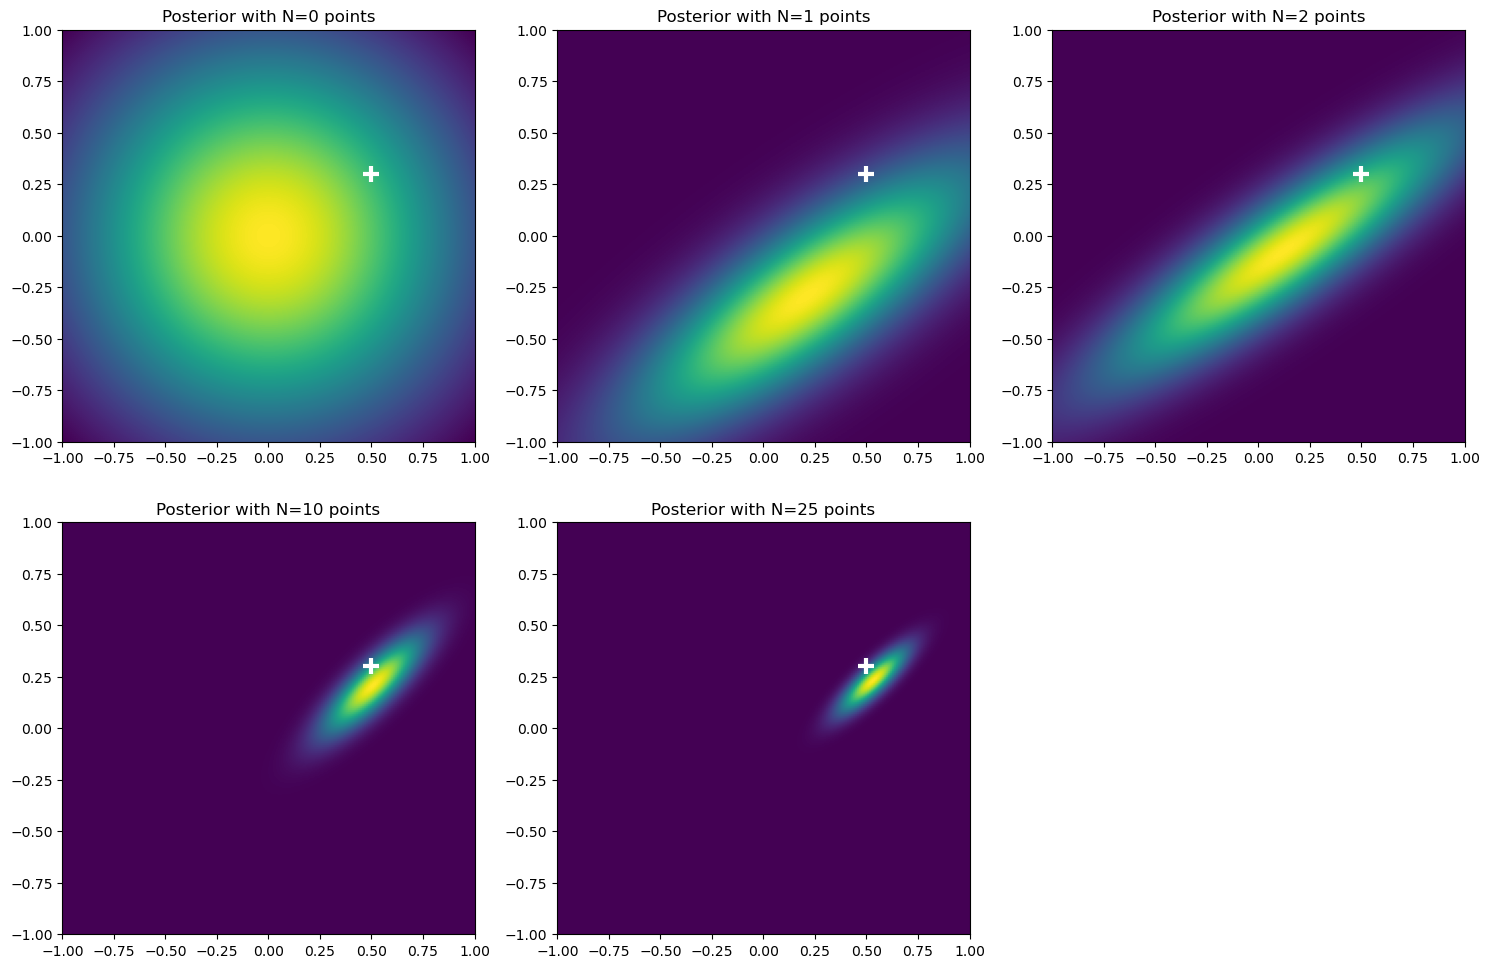

In [7]:
alpha = dataset_linear['ALPHA']
beta = dataset_linear['BETA']

plt.figure(figsize=(15, 10))

for count, n in enumerate([0, 1, 2, 10, len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2, 1))
    posterior = np.zeros((meshgrid.shape[0], meshgrid.shape[0]))

    if n == 0:  # Pas de données : a posteriori = a priori
        mu_N = np.zeros((2, 1))  # Moyenne du prior
        sigma_N = np.eye(2) / alpha  # Covariance du prior
    else:
        # Construire la matrice de design Phi pour les données actuelles
        Phi = phi_linear(cur_data)
        # Calcul de sigma_N (matrice de covariance a posteriori)
        sigma_N_inv = alpha * np.eye(2) + beta * Phi.T @ Phi
        sigma_N = np.linalg.inv(sigma_N_inv)
        # Calcul de mu_N (moyenne a posteriori)
        mu_N = beta * sigma_N @ Phi.T @ cur_lbl.reshape(-1, 1)

    # Compute values on meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0, 0] = meshgrid[i]
            w[1, 0] = meshgrid[j]
            posterior[i, j] = np.exp(-0.5 * np.dot(np.dot(
                (w-mu_N.reshape(2, 1)).T, np.linalg.inv(sigma_N)), (w-mu_N.reshape(2, 1))).item())
    
    Z = 1.0 / (np.sqrt(2*np.pi * np.linalg.det(sigma_N)))
    posterior[:, :] /= Z

    # Plot posterior with n points
    plt.subplot(231+count)
    plt.imshow(posterior, extent=[-1, 1, -1, 1])
    plt.plot(0.5, 0.3, '+', markeredgecolor='white',
             markeredgewidth=3, markersize=12)
    plt.title('Posterior with N={} points'.format(n))
    
plt.tight_layout()
plt.show()

The previous plots show the posterior distribution in our parameter space. In this case of 1D linear regression, our parameter vector $w$ is a 2D vector $w = (w_0, w_1)^T$ whose values we fixed before as $w_0 = 0.5$ and $w_1 = 0.3$. This ground truth value is shown in the previous plots with a white cross (+). The plots show how as we increase the number of points, the posterior distribution becomes narrower (the covariances decrease) and converges towards the ground truth values. 

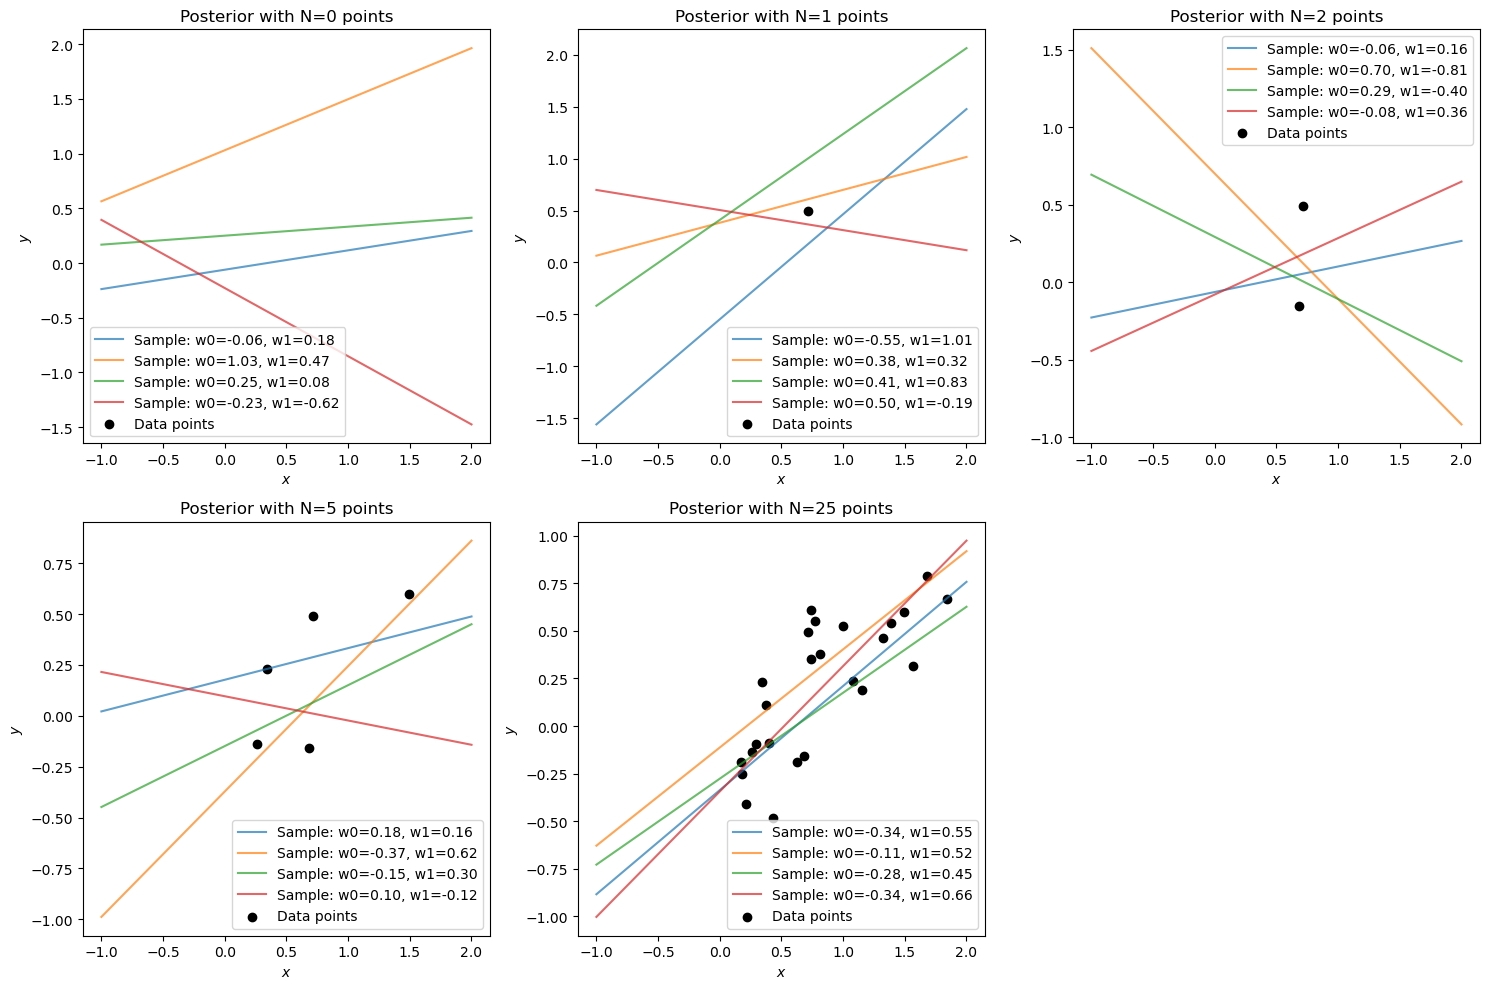

In [8]:
# Paramètres initiaux
alpha = 2.0  # Précision du prior
beta = 1/(2.0*sigma**2)  # Précision du bruit
meshgrid = np.arange(-1, 1.01, 0.01)

# Début de la visualisation
plt.figure(figsize=(15, 10))
all_samples = []

for count, n in enumerate([0, 1, 2, 5, len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]

    if n == 0:  # Pas de données : a posteriori = a priori
        mu_N = np.zeros((2, 1))  # Moyenne du prior
        sigma_N = np.eye(2) / alpha  # Covariance du prior
    else:
        # Construire la matrice de design Phi pour les données actuelles
        Phi = phi_linear(cur_data)
        # Calcul de sigma_N (matrice de covariance a posteriori)
        sigma_N_inv = alpha * np.eye(2) + beta * Phi.T @ Phi
        sigma_N = np.linalg.inv(sigma_N_inv)
        # Calcul de mu_N (moyenne a posteriori)
        mu_N = beta * sigma_N @ Phi.T @ cur_lbl.reshape(-1, 1)

    # Échantillonnage de la distribution des poids
    samples = np.random.multivariate_normal(mu_N.flatten(), sigma_N, size=4)
    all_samples.append(samples)

    # Génération des points à partir des échantillons de la distribution linéaire
    x_points = np.linspace(-1, 2, 1000)
    plt.subplot(2, 3, count + 1)
    for sample in samples:
        y_points = sample[0] + sample[1] * x_points  # Génère y = w0 + w1*x
        plt.plot(x_points, y_points,
                 label=f'Sample: w0={sample[0]:.2f}, w1={sample[1]:.2f}', alpha=0.7)
    plt.scatter(cur_data, cur_lbl, color='black', label='Data points')
    plt.title(f'Posterior with N={n} points')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()

plt.tight_layout()
plt.show()

In these plots, we visualize the same result in a different way. Given a posterior distribution, we randomly sample four values of the parameter vector $w$ from the posterior distribution. Then, we plot the predictions corresponding to these parameters. We see again that the distribution of $w$ converges towards the ground truth as we increase the number of data points. 

**Question 1.3: Recall and code closed form of the predictive distribution in linear case.**

In Bayesian Linear Regression, the predictive distribution is obtained by marginalizing over the posterior distribution of the weights $w$. Using Bayes' theorem, the predictive distribution for a new input $x^*$ is:

$$
\boxed{p(y \mid x^*, X, Y, \alpha, \beta) = \int p(y \mid x^*, w, \beta) \, p(w \mid X, Y, \alpha, \beta) \, dw}
$$

For a given weight vector $w$, the likelihood of the prediction is Gaussian (as showed before):
$$
p(y \mid x^*, w) = \mathcal{N}(y \,\, ; \,\, \Phi(x^*)^T w, \, (2\beta)^{-1})
$$
where:
- $\Phi(x^*)$ is the design vector for the new input $x^*$.

The posterior distribution of the weights $w$ (from **Answer 1.2**) is:
$$
p(w \mid X, Y, \alpha, \beta) = \mathcal{N}(w; \mu, \Sigma)
$$

By integrating the product of the likelihood and the posterior over all possible weights $w$, we find that the predictive distribution is also Gaussian:
$$
p(y \mid x^*, X, Y, \alpha, \beta) = \mathcal{N}(y; \mu_{\text{pred}}(x^*), \sigma_{\text{pred}}^2(x^*) )
$$
with:
- Predictive mean:
$$
\boxed{\mu_{\text{pred}}(x^*) = \mu^T \Phi(x^*)}
$$
- Predictive variance:
$$
\boxed{\sigma_{\text{pred}}^2(x^*) = \frac{1}{\beta} + \Phi(x^*)^T \Sigma \Phi(x^*)}
$$

Interpretation of Predictive Distribution:
- The **mean** of the predictive distribution represents the model's most likely prediction for $y$ at $x^*$.
- The **variance** consists of two components:
  1. **Aleatoric uncertainty** $\frac{1}{\beta}$: Inherent noise in the data.
  2. **Epistemic uncertainty** $\Phi(x^*)^T \Sigma \Phi(x^*)$: Uncertainty in the weights w, which decreases as more data is observed.

This closed-form solution provides the predictive distribution for Bayesian Linear Regression.


In [9]:
def closed_form(func, X_train, y_train, alpha, beta):
    """
    Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen, the
    training set (X_train, y_train) and the noise precision parameter beta and prior precision parameter alpha chosen.
    It should return a function outputing both mean and std of the predictive distribution at a point x*.

    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter

    Returns:
      (function) prediction function, returning itself both mean and std
    """
    # 1. Apply the basis function to X_train
    Phi = func(X_train)

    # 2. Compute posterior covariance Σ:
    I = np.eye(Phi.shape[1])  # Identity matrix
    Sigma_inv = alpha * I + beta * Phi.T @ Phi
    Sigma = np.linalg.inv(Sigma_inv)

    # 3. Compute posterior mean μ:
    mu = beta * Sigma @ Phi.T @ y_train  # Shape: [p+1,]

    # Define the prediction function
    def f_model(x):
        """
        Predictive distribution for a new point x.
        Returns the mean and standard deviation of the prediction.
        """
        # 1. Apply basis function to x*
        phi_x = np.array(func(x))  # Shape: [p+1,]

        # 2. Predictive mean:
        pred_mean = phi_x @ mu  # Scalar

        # 3. Predictive variance:
        pred_var = 1 / beta + phi_x @ Sigma @ phi_x.T  # Scalar

        # Predictive std:
        pred_std = np.sqrt(pred_var)

        return pred_mean, pred_std

    return f_model

In [10]:
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'],
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

In [11]:
dataset_linear['ALPHA'], dataset_linear['BETA']

(2.0, 12.499999999999998)

In [12]:
f_pred = closed_form(
    phi_linear,
    dataset_linear["X_train"],
    dataset_linear["y_train"],
    dataset_linear["ALPHA"],
    dataset_linear["BETA"],
)

# Predict mean and std for a given point x=0
f_pred(np.array([0]))

(array([-0.22946111]), array([[0.30199235]]))

**Question 1.4: Based on previously defined ``f_pred()``, predict on the test dataset. Then visualize results using ``plot_results()`` defined at the beginning of the notebook.**

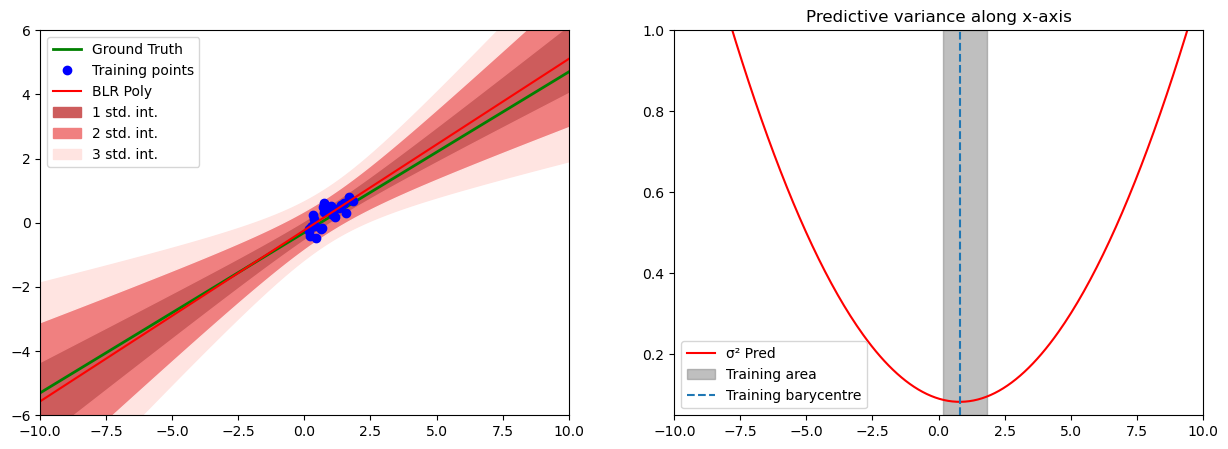

In [13]:
y_pred = []
std_pred = []

for x in dataset_linear['X_test']:
    x = np.array([x])
    # Obtenir la moyenne et l'écart-type pour chaque point x
    pred_mean, pred_std = f_pred(x)
    y_pred.append(pred_mean)
    std_pred.append(pred_std)

y_pred = np.array(y_pred)
std_pred = np.array(std_pred)
y_pred = y_pred.squeeze(-1)
std_pred = std_pred.squeeze(-1).squeeze(-1)

# Appeler plot_results pour visualiser les prédictions
plot_results(
    dataset_linear['X_train'], dataset_linear['y_train'], dataset_linear['X_test'], dataset_linear['y_test'], y_pred, std_pred,
    xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1
)


In the left figure, the red line (BLR Poly) represents the predicted regression line using Bayesian Linear Regression, which closely follows the ground truth in the training area. Near the training points (blue dots), the confidence intervals are narrower, reflecting low epistemic uncertainty due to the model's confidence in these regions. However, far from the training points, the intervals widen, indicating high epistemic uncertainty where the model lacks data support. In the right figure, the red curve shows the predictive variance along the x-axis, which is lowest near the training area (gray shaded region) and smallest around the barycenter of the training points (dashed blue line). The variance increases as we move away from the training region, highlighting the model's reduced confidence and inability to reliably predict in areas without data.

**Question 1.5: Analyse these results. Why predictive variance increases far from training distribution? Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

In Bayesian Linear Regression, the predictive variance increases as we move away from the training distribution because the model becomes less confident in its predictions. This reflects the **epistemic uncertainty**, which arises due to limited training data in those regions. The predictive variance is composed of two components:
$$
\sigma_{\text{pred}}^2(x^*) = \frac{1}{\beta} + \Phi(x^*)^T \Sigma \Phi(x^*),
$$
where:
- $\frac{1}{\beta}$ represents the aleatoric uncertainty, which is constant.
- $\Phi(x^*)^T \Sigma \Phi(x^*)$ represents the epistemic uncertainty, which depends on the distance of $x^*$ from the training points.

*As $x^*$ moves far from the training distribution, the contribution of $\Phi(x^*)^T \Sigma \Phi(x^*)$ increases, leading to higher predictive variance*.

---

In the case where $\alpha = 0$ (no prior regularization) and $\beta = 1$ (noise precision is 1), the posterior covariance becomes:

$$
\Sigma = (\Phi^T \Phi)^{-1}.
$$

The predictive variance is:
$$
\sigma_{\text{pred}}^2(x^*) = \frac{1}{\beta} + \Phi(x^*)^T \Sigma \Phi(x^*).
$$
Substituting $\beta = 1$, this simplifies to:
$$
\sigma_{\text{pred}}^2(x^*) = 1 + \Phi(x^*)^T (\Phi^T \Phi)^{-1} \Phi(x^*).
$$

To analyse Why predictive variance increases far from training distribution, we will simplify the term $\Phi(x^*)^T (\Phi^T \Phi)^{-1} \Phi(x^*)$ as its the only term that depend on $x^*$, lets start with simplifying:

$$
\Sigma^{-1} = \Phi^T \Phi
$$

in the case of one dimension input we can write $\Sigma^{-1}$ as:

$$
\Phi^T \Phi =
\begin{pmatrix}
1 & \dots & 1 \\
x_1 & \dots & x_N
\end{pmatrix}
\begin{pmatrix}
1 & x_1 \\
\vdots & \vdots \\
1 & x_N
\end{pmatrix}
$$

$$
 =
\begin{pmatrix}
N & \sum x_i \\
\sum x_i & \sum x_i^2
\end{pmatrix}
$$

Finally, we find the formulas of $\Sigma$:

$$
\Sigma = \frac{1}{\det \Sigma^{-1}}
\begin{pmatrix}
\sum x_i^2 & -\sum x_i \\
-\sum x_i & N
\end{pmatrix}
$$

Now, We can write $\Phi(x^*)^T \Sigma \Phi(x^*)$ as:

$$
\Phi(x^*)^T \Sigma \Phi(x^*) = \frac{1}{\det \Sigma^{-1}}
\begin{pmatrix}
1 & x^*
\end{pmatrix}
\begin{pmatrix}
\sum x_i^2 & -\sum x_i \\
-\sum x_i & N
\end{pmatrix}
\begin{pmatrix}
1 \\
x^*
\end{pmatrix}
$$

$$
= \frac{1}{\det \Sigma^{-1}}
\begin{pmatrix}
1 & x^*
\end{pmatrix}
\begin{pmatrix}
\sum x_i^2 - x^* \sum x_i \\
x^* N - \sum x_i
\end{pmatrix}
$$

$$
= \frac{1}{\det \Sigma^{-1}}
\begin{pmatrix}
\sum_{i=1}^N x_i^2 - 2 x^* \sum_{i=1}^N x_i + (x^*)^2 N
\end{pmatrix}
$$

$$
= \frac{1}{\det \Sigma^{-1}}
\begin{pmatrix}
\sum_{i=1}^N (x_i^2 - 2 x^* x_i + (x^*)^2)
\end{pmatrix}
$$

Finally, we can write our predective variance $\sigma_{\text{pred}}^2$ as:

$$
\boxed{\sigma_{\text{pred}}^2 = 1 + \frac{1}{\det \Sigma^{-1}} \sum_{i=1}^N (x_i - x^*)^2}
$$


---

This boxed formula tells us a lot of important information to capture:

- **First**, the term $\frac{1}{\det \Sigma^{-1}} \sum_{i=1}^N (x_i - x^*)^2$ shows that as we move farther from the training data points, the predictive variance increases, as this term grows larger mathematically (it's a positive term since $\det \Sigma^{-1} = N \sum_{i=1}^N x_i^2 - (\sum_{i=1}^N x_i)^2$ is positive thanks to the inequality of cauchy-schwarz). This reflects the **epistemic uncertainty**, which arises from the lack of training data in those regions. The farther $x^*$ is from the training data, the higher the uncertainty, as the model has no information to constrain its predictions.

- **Second**, the predictive variance $\sigma_{\text{pred}}^2$ is always bounded from below by the aleatoric uncertainty $\frac{1}{\beta}$. This is because $\sigma_{\text{pred}}^2$ is the sum of $\frac{1}{\beta}$ (a strictly positive number) and another positive term $\frac{1}{\det \Sigma^{-1}} \sum_{i=1}^N (x_i - x^*)^2$ (Knowing that $\det \Sigma^{-1} = N \sum_{i=1}^N x_i^2 - (\sum_{i=1}^N x_i)^2$ is positive thanks to the inequality of cauchy-schwarz). This behavior is expected because even if we overcome epistemic uncertainty (by significantly increasing and varying the training data—though this can never be fully achieved, as explained in the third point), the **aleatoric noise** can be always present. Therefore, we can conclude:

$$
\boxed{\sigma_{\text{pred}}^2 > \frac{1}{\beta}}
$$

- **Third**, the only scenario where there would be no epistemic uncertainty is when $\frac{1}{\det \Sigma^{-1}} \sum_{i=1}^N (x_i - x^*)^2 = 0$. Mathematically, this happens if and only if $x^* = x_i$ for all existing $i$. In other words, this corresponds to the case where the training data consists of only one point. However, in this situation, $\det \Sigma^{-1} = 0$, meaning that the matrix $\Sigma$ is not invertible. This makes perfect sense because, to define a line, we need at least two points. Therefore, the conclusion is that **epistemic uncertainty can never be completely eliminated**.

- **Forth**, from the boxed formula, we can extend the calculations to find where the predicted variance achieves its minimum. To do so, we compute the derivative of the boxed formula with respect to $x^*$:

$$
\frac{\partial \sigma_{\text{pred}}^2}{\partial x^*} = \frac{1}{\det \Sigma^{-1}} \sum_{i=1}^N 2(x^* - x_i) \equiv 0
$$

Simplifying, we get:

$$
\sum_{i=1}^N (x^* - x_i) \equiv 0
$$

Expanding and rearranging:

$$
\sum_{i=1}^N x^* = \sum_{i=1}^N x_i
$$

Factoring out $x^*$:

$$
x^* N = \sum_{i=1}^N x_i
$$

Finally, dividing by N:

$$
\boxed{x_{min}^* = \frac{\sum_{i=1}^N x_i}{N}}
$$

This result indicates that the predicted variance reaches its minimum at the **barycenter** of the training points.

--- 

This formula elegantly separates the contributions of **aleatoric uncertainty** (the constant term "1") and **epistemic uncertainty** (the term involving $\frac{1}{\det \Sigma^{-1}} \sum_{i=1}^N (x_i - x^*)^2$), providing clear insight into how the model handles uncertainty in predictions.

**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

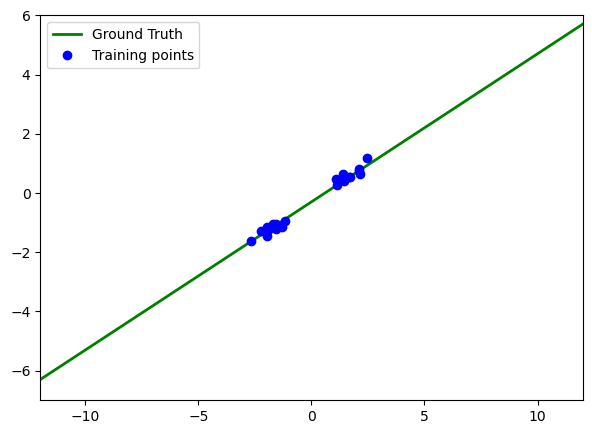

In [14]:
# Create training and test points
sigma = 0.2
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(
    ([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(
    dataset_hole['X_train'], noise_amount=1, sigma=sigma)
dataset_hole['X_test'] = np.linspace(-12, 12, 100)
dataset_hole['y_test'] = f_linear(
    dataset_hole['X_test'], noise_amount=0, sigma=sigma)
dataset_hole['ALPHA'] = 2.0
dataset_hole['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7, 5))
plt.xlim(xmin=-12, xmax=12)
plt.ylim(ymin=-7, ymax=6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'],
         color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'],
         'o', color='blue', label='Training points')
plt.legend()
plt.show()

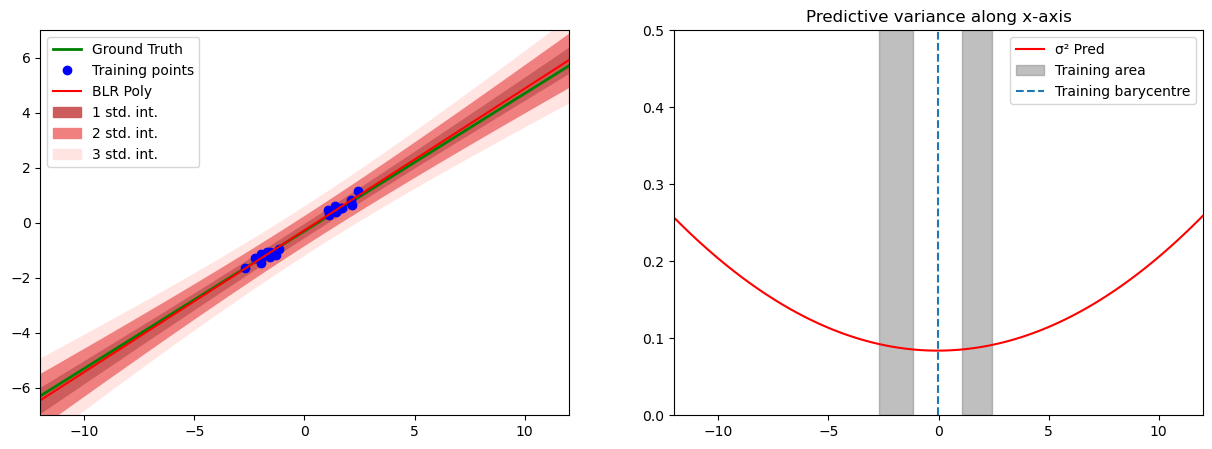

In [15]:
f_pred = closed_form(
    phi_linear,
    dataset_hole["X_train"],
    dataset_hole["y_train"],
    dataset_hole["ALPHA"],
    dataset_hole["BETA"],
)
y_pred = []
std_pred = []

for x in dataset_hole['X_test']:
    x = np.array([x])
    # Obtenir la moyenne et l'écart-type pour chaque point x
    pred_mean, pred_std = f_pred(x)
    y_pred.append(pred_mean)
    std_pred.append(pred_std)

y_pred = np.array(y_pred)
std_pred = np.array(std_pred)
y_pred = y_pred.squeeze(-1)
std_pred = std_pred.squeeze(-1).squeeze(-1)

# Appeler plot_results pour visualiser les prédictions
plot_results(
    dataset_hole['X_train'], dataset_hole['y_train'], dataset_hole['X_test'], dataset_hole['y_test'], y_pred, std_pred,
    xmin=-12, xmax=12, ymin=-7, ymax=7, stdmin=0.0, stdmax=0.5
)

# You should use the following parameters for plot_results
# xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5

The first notable observation from the figures is that the lowest uncertainty is found in the region between the two clusters of the training area. This is surprising, as there are no training points in this gap. However, as demonstrated in the previous question, the predicted variance theoretically reaches its minimum at the barycenter of the training points. This highlights a limitation of the model, as it tends to underestimate uncertainty in such regions (where we have this gap between the training data), leading to overconfidence in predictions in such areas. This fact is a consequence of our posterior being modeled as a Gaussian, which is unimodal, while we would need a multimodal function to fit edge cases such as this. 

The second observation is that we observe very low uncertainty over a large interval of points. This can be intuitively explained by noting that when we draw a line between two distant points, the line's slope and direction are more constrained and certain compared to drawing a line between two points that are very close to each other. In this case, the training clusters being far apart provide the model with more information about the overall trend, reducing uncertainty over a larger range of the input space.

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

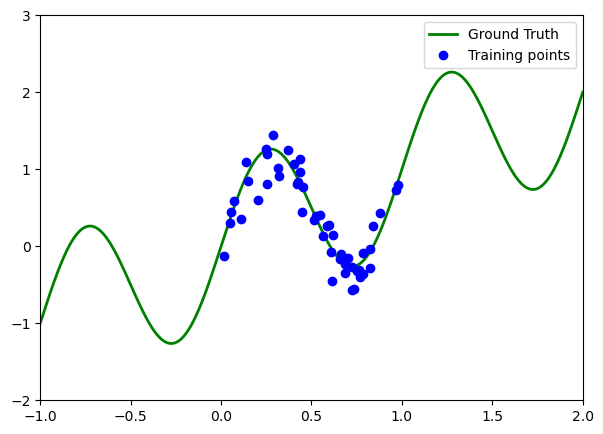

In [16]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount, sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create training and test points
sigma = 0.2
nbpts = 50
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpts)
dataset_sinus['y_train'] = f_sinus(
    dataset_sinus['X_train'], noise_amount=1, sigma=sigma)
dataset_sinus['X_test'] = np.linspace(-1, 2, 10*nbpts)
dataset_sinus['y_test'] = f_sinus(
    dataset_sinus['X_test'], noise_amount=0, sigma=sigma)

dataset_sinus['ALPHA'] = 0.05
dataset_sinus['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7, 5))
plt.xlim(xmin=-1, xmax=2)
plt.ylim(ymin=-2, ymax=3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'],
         'o', color='blue', label='Training points')
plt.legend()
plt.show()

### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_{D-1})$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_n & x_n^2 &... &x_n^{D-1}
  \end{bmatrix}
$$

**Question 2.1: Code polynomial basis function**

In [17]:
# Define basis function
def phi_polynomial(x, D=10):
    """
    Polynomial Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) polynomial features of x
    """
    n = len(x)
    Phi = np.ones((n, 1))
    for i in range(1, D):
        X = x**i
        Phi = np.hstack((Phi, X.reshape(-1, 1)))
    return Phi

In [18]:
phi_polynomial(np.array([1, 2, 3]), D=3)

array([[1., 1., 1.],
       [1., 2., 4.],
       [1., 3., 9.]])

**Question 2.2 : Code and visualize results on sinusoidal dataset using polynomial basis functions. What can you say about the predictive variance?**

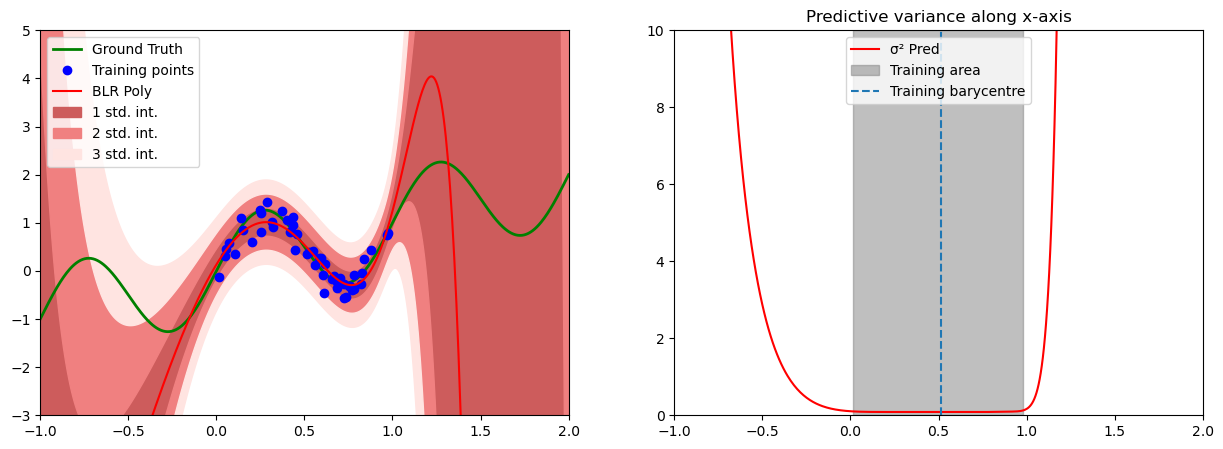

In [19]:
f_pred = closed_form(
    phi_polynomial,
    dataset_sinus["X_train"],
    dataset_sinus["y_train"],
    dataset_sinus["ALPHA"],
    dataset_sinus["BETA"],
)

y_pred = []
std_pred = []

for x in dataset_sinus['X_test']:
    x = np.array([x])
    # Obtenir la moyenne et l'écart-type pour chaque point x
    pred_mean, pred_std = f_pred(x)
    y_pred.append(pred_mean)
    std_pred.append(pred_std)

y_pred = np.array(y_pred)
std_pred = np.array(std_pred)
y_pred = y_pred.squeeze(-1)
std_pred = std_pred.squeeze(-1).squeeze(-1)

# Appeler plot_results pour visualiser les prédictions
plot_results(
    dataset_sinus['X_train'], dataset_sinus['y_train'], dataset_sinus['X_test'], dataset_sinus['y_test'], y_pred, std_pred,
    xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10
)
# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10

The polynomial basis function aligns very closely with the training data resulting in very low predictive variance in the training area. However, we also observe that the epistemic uncertainty increases very quickly outside this area, as shown by the high predictive variance outside of the training area.

### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_M)$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_M(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_n) & \phi_1(x_n) &... &\phi_M(x_n)
  \end{bmatrix}
$$

**Question 2.3: Code gaussian basis function**

In [20]:
MU_MIN = 0
MU_MAX = 1
M = 9  # number of basis functions 

def phi_gaussian(x):
    """
    Gaussian Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) gaussian features of x
    """
    s = (MU_MAX-MU_MIN)/M  # step size
    #return np.exp(-1 * (x - np.arange(MU_MIN, MU_MAX, s)) ** 2 / (2 * s * s))
    Phi = np.zeros((len(x), M))
    for j in range(M):
        Phi[:, j] = np.exp(-1 * (x - (MU_MIN + j * s)) ** 2 / (2 * s * s))
    return Phi

In [21]:
print(phi_gaussian(np.array([0, 0.5, 1])).shape)
print(phi_gaussian(np.array([0, 0.5, 1])))

(3, 9)
[[1.00000000e+00 6.06530660e-01 1.35335283e-01 1.11089965e-02
  3.35462628e-04 3.72665317e-06 1.52299797e-08 2.28973485e-11
  1.26641655e-14]
 [4.00652974e-05 2.18749112e-03 4.39369336e-02 3.24652467e-01
  8.82496903e-01 8.82496903e-01 3.24652467e-01 4.39369336e-02
  2.18749112e-03]
 [2.57675711e-18 1.26641655e-14 2.28973485e-11 1.52299797e-08
  3.72665317e-06 3.35462628e-04 1.11089965e-02 1.35335283e-01
  6.06530660e-01]]


**Question 2.4 : Code and visualize results on sinusoidal dataset using Gaussian basis functions. What can you say this time about the predictive variance?**

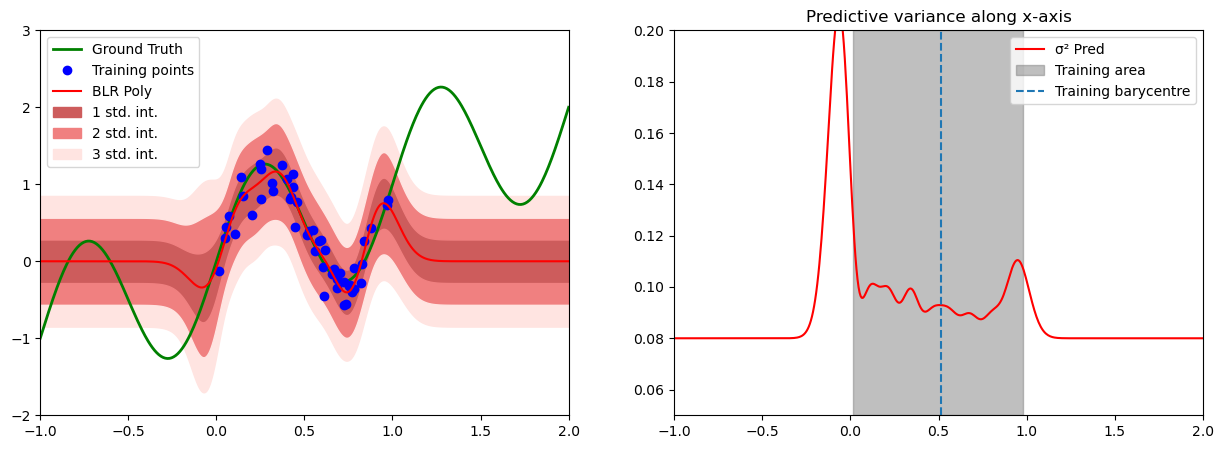

In [22]:
# TO DO: Define f_pred, predict on test points and plot results
f_pred = closed_form(
    phi_gaussian,
    dataset_sinus["X_train"],
    dataset_sinus["y_train"],
    dataset_sinus["ALPHA"],
    dataset_sinus["BETA"],
)

y_pred = []
std_pred = []

for x in dataset_sinus['X_test']:
    x = np.array([x])
    # Obtenir la moyenne et l'écart-type pour chaque point x
    pred_mean, pred_std = f_pred(x)
    y_pred.append(pred_mean)
    std_pred.append(pred_std)

y_pred = np.array(y_pred)
std_pred = np.array(std_pred).reshape(-1)
y_pred = y_pred.squeeze(-1)

# Appeler plot_results pour visualiser les prédictions
plot_results(
    dataset_sinus['X_train'], dataset_sinus['y_train'], dataset_sinus['X_test'], dataset_sinus['y_test'], y_pred, std_pred,
    xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2
)
# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2

For the Gaussian basis, we observe quite a different behaviour in the predictive variance. Firstly, we notice that the predictive variance along the x-axis is no longer a convex function with a minimum approximately aligned with the barycentre of the training points. On the contrary, we now have that the predictive variance is lowest far from the training area. Moreover, we observe that the predictive variance is quite irregular and peaked. In particular, the highest variance doesn't occur far from the training area, but in a peak just outside it. 

This behaviour comes from how we defined the design matrix $\Phi$. For the Gaussian basis, we choose a range of mean values $\mu_j$ which are the means of the Gaussian basis functions. In this particular case, we're choosing evenly spaced values encompassing the whole training area ($\mu \in [0, 1]$) and thus we see the model aligning closely with the mean of the training data in this range, while remaining constant (and thus having zero variance) far from this range. 



**Question 2.5: Explain why in regions far from training distribution, the predictive variance converges to this value when using localized basis functions such as Gaussians.**

We define the Radial Basis Function as:

$$
\Phi_j(x_i) = \exp\!\Bigl(\!-\frac{(x_i - \mu_j)^2}{2\,s^2}\Bigr)
$$

where $\mu_j$ represents the mean of the $j$-th Gaussian basis function. We observe that $\Phi_j(x)$ has its peak at $x = \mu_j$ and exponentially decreases towards zero as $x$ moves farther from its mean. Let's recall the expression for the predictive variance:

$$
\sigma_{pred}^2 
= \beta^{-1} + \Phi(x^*)^{T} \Sigma \,\Phi(x^*) 
$$

We can then observe that if $x^*$ is far from $\mu_j$ for all of the $j$ basis functions, then $\sigma_{pred}^2 \approx \beta^{-1}$. This means that the predictive variance is effectively reduced to aleatoric uncertainty. We observe this behaviour in the previous plot, where $\sigma_{pred}^2 = \beta^{-1} = 0.08$ far from the training area.